# Text Analysis with TFIDF

In [1]:
import re
import numpy as np
np.random.seed(0)
import scipy.sparse as sp
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Load federalist papers data

#### Text data are collected from [Project Gutenberg](http://www.gutenberg.org/ebooks/18)

Preprocess the data so that unwanted information will not be processed later, get the author and content of each paper, and have the text tokenized.

In [2]:
def load_federalist_corpus(filename):
    """ Load the federalist papers as a tokenized list of strings, one for each eassay"""
    with open(filename, "rt",encoding = "utf8") as f:
        data = f.read()
    papers = data.split("FEDERALIST")
    
    # all start with "To the people of the State of New York:" (sometimes . instead of :)
    # all end with PUBLIUS (or no end at all)
    locations = [(i,[-1] + [m.end()+1 for m in re.finditer(r"of the State of New York", p)],
                 [-1] + [m.start() for m in re.finditer(r"PUBLIUS", p)]) for i,p in enumerate(papers)]
    papers_content = [papers[i][max(loc[1]):max(loc[2])] for i,loc in enumerate(locations)]

    # discard entries that are not actually a paper
    papers_content = [p for p in papers_content if len(p) > 0]

    # replace all whitespace with a single space
    papers_content = [re.sub(r"\s+", " ", p).lower() for p in papers_content]

    # add spaces before all punctuation, so they are separate tokens
    punctuation = set(re.findall(r"[^\w\s]+", " ".join(papers_content))) - {"-","'"}
    for c in punctuation:
        papers_content = [p.replace(c, " "+c+" ") for p in papers_content]
    papers_content = [re.sub(r"\s+", " ", p).lower().strip() for p in papers_content]
    
    authors = [tuple(re.findall("MADISON|JAY|HAMILTON", a)) for a in papers]
    authors = [a for a in authors if len(a) > 0]
    
    numbers = [re.search(r"No\. \d+", p).group(0) for p in papers if re.search(r"No\. \d+", p)]
    
    return papers_content, authors, numbers

In [3]:
papers, authors, numbers = load_federalist_corpus("utility/pg18.txt")

## Build TFIDF matrix from list of documents

In [4]:
def build_tfidf(docs):
    """
    Args:
        docs: list of strings, where each string represents a space-separated
              document
    
    Returns: tuple: (tfidf, all_words)
        tfidf: sparse matrix (in any scipy sparse format) of size (# docs) x
               (# total unique words), where i,j entry is TFIDF score for 
               document i and term j
        all_words: list of strings, where the ith element indicates the word
                   that corresponds to the ith column in the TFIDF matrix
    """
    record = set()
    words, row, col, data, whole = [], [], [], [], [] 
    num_doc_with, idf = {}, {}
    for doc in docs:
        this = set()
        counter = {}
        for word in doc.split():
            counter[word] = counter.get(word,0) + 1
            if word not in record:
                words.append(word)
                record.add(word)
            if word not in this:
                num_doc_with[word] = num_doc_with.get(word,0) + 1
                this.add(word)
        whole.append(counter)
        
    # inverse document frequency
    for word in num_doc_with:
        idf[word] = np.log(len(docs)/num_doc_with[word])
    for doc_num in range(len(docs)):
        for word_num, word in enumerate(words):
            if word in whole[doc_num]:
                row.append(doc_num)
                col.append(word_num)
                data.append(idf[word] * whole[doc_num][word])
            
    tfidf = sp.coo_matrix((data,(row,col)),shape=(len(docs),len(words)))

    return (tfidf,words)

In [5]:
tfidf, words = build_tfidf(papers)

## Calculate cosine similarity between documents

In [6]:
def cosine_similarity(X):
    """
    Return a matrix of cosine similarities.
    
    Args:
        X: sparse matrix of TFIDF scores or term frequencies
    
    Returns:
        M: dense numpy array of all pairwise cosine similarities.  That is, the 
           entry M[i,j], should correspond to the cosine similarity between the 
           ith and jth rows of X.
    """
    cos = np.zeros((X.shape[0],X.shape[0]))
    X = X.todense()
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            cos[i,j] = X[i,:].dot(X[j,:].T)/np.linalg.norm(X[i,:])/np.linalg.norm(X[j,:])
    return cos

In [7]:
cosine = cosine_similarity(tfidf)

### Check if documents from the same author share higher cosine similarity than those from different authors

In [8]:
hamilton = {i for i,author in enumerate(authors) if 'HAMILTON' in author}

In [9]:
ham = [cosine[i,j] for i in range(len(authors)) for j in range(len(authors))\
           if i in hamilton and j in hamilton and i != j]
other = [cosine[i,j] for i in range(len(authors)) for j in range(len(authors))\
           if i in hamilton and j not in hamilton]

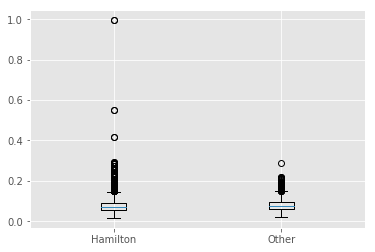

In [10]:
both = [ham,other]
plt.boxplot(both)
plt.xticks([1,2],['Hamilton','Other'])
plt.show()

### Evaluate model by comparing unknown documents to each TFIDF model of author-known documents

In [11]:
data, labels = [], []
for i, author in enumerate(authors):
    if len(author) == 1:
        labels.append(author[0])
        data.append(i)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data,labels)

In [14]:
hamilton = [papers[i] for i in X_train if authors[i][0] == 'HAMILTON']
madison = [papers[i] for i in X_train if authors[i][0] == 'MADISON']
jay = [papers[i] for i in X_train if authors[i][0] == 'JAY']
tests = [papers[i] for i in X_test]

In [15]:
test_labels = []
for te in tests:
    with_ham, with_jay, with_mad = map(build_tfidf, [hamilton + [te], jay + [te], madison + [te]])
    cos_ham, cos_jay, cos_mad = map(cosine_similarity, [with_ham[0], with_jay[0], with_mad[0]])
    mean_ham = sum(cos_ham[-1,:-1])/cos_ham.shape[0]
    mean_jay = sum(cos_jay[-1,:-1])/cos_jay.shape[0]
    mean_mad = sum(cos_mad[-1,:-1])/cos_mad.shape[0]
    mx = max(mean_ham, mean_jay, mean_mad)
    if mx == mean_ham:
        test_labels.append('HAMILTON')
    elif mx == mean_jay:
        test_labels.append('JAY')
    else:
        test_labels.append('MADISON')

In [16]:
right = 0
for i in range(len(y_test)):
    if y_test[i] == test_labels[i]:
        right += 1
print('accuracy:{:.2f}%'.format(100 * right / len(y_test)))

accuracy:77.78%


__Conclusion__: TFIDF is powerful in comparing two documents' similarity, thus it's been widely used in search, topic modelling, or keyword extraction and in the author classification example above, though it's already achieved good accuracy, however, we can still make it more accurate if we increase the amount of data.